# Analysis after running the analysis/crowdsource catalogs


Run these as batch jobs 
```
analysis/crowdsource_catalogs_long.py
analysis/crowdsource_catalogs_short.py
```

In [1]:
cd /orange/adamginsburg/jwst/brick/

/orange/adamginsburg/jwst/brick


In [2]:
basepath = '/orange/adamginsburg/jwst/brick/'

In [3]:
from astropy import coordinates

In [4]:
import numpy as np

In [5]:
from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DAOGroup, IntegratedGaussianPRF, extract_stars, IterativelySubtractedPSFPhotometry, BasicPSFPhotometry

In [6]:
import warnings

In [7]:
import regions

In [8]:
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter

In [9]:
from astropy import stats
from astropy.table import Table
from astropy.wcs import WCS

In [10]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy import wcs
from astropy import table
from astropy import units as u
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['figure.figsize'] = (10,8)

In [11]:
import glob
from astropy.io import fits

In [12]:
filternames = ['f410m', 'f212n', 'f466n', 'f405n', 'f187n', 'f182m']

In [13]:
#catfns = glob.glob(f"{basepath}/F*/f[0-9][0-9][0-9][nm]*nrca_crowdsource.fits")
catfns = [x
          for filn in filternames
          for x in glob.glob(f"{basepath}/{filn.upper()}/{filn.lower()}*nrca_crowdsource.fits")
         ]
catfns

['/orange/adamginsburg/jwst/brick//F410M/f410m_nrca_crowdsource.fits',
 '/orange/adamginsburg/jwst/brick//F212N/f212n_nrca_crowdsource.fits',
 '/orange/adamginsburg/jwst/brick//F466N/f466n_nrca_crowdsource.fits',
 '/orange/adamginsburg/jwst/brick//F405N/f405n_nrca_crowdsource.fits',
 '/orange/adamginsburg/jwst/brick//F187N/f187n_nrca_crowdsource.fits',
 '/orange/adamginsburg/jwst/brick//F182M/f182m_nrca_crowdsource.fits']

In [14]:
# jw02221-o001_t001_nircam_f405n-f444w_i2d.fits
# /orange/adamginsburg/jwst/brick//F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrca_i2d.fits
imgfns = [x
          for filn in filternames
          for x in glob.glob(f"{basepath}/{filn.upper()}/pipeline/jw02221-o001_t001_nircam*{filn.lower()}*nrca*_i2d.fits")
          if 'nrca_' in x or 'nrca1_' in x
         ]

print(" ".join(imgfns))
imgfns

/orange/adamginsburg/jwst/brick//F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits /orange/adamginsburg/jwst/brick//F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrca_i2d.fits /orange/adamginsburg/jwst/brick//F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrca1_i2d.fits /orange/adamginsburg/jwst/brick//F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrca_i2d.fits /orange/adamginsburg/jwst/brick//F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrca_i2d.fits /orange/adamginsburg/jwst/brick//F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrca_i2d.fits /orange/adamginsburg/jwst/brick//F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrca1_i2d.fits /orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrca_i2d.fits /orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrca1_i2d.fits


['/orange/adamginsburg/jwst/brick//F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits',
 '/orange/adamginsburg/jwst/brick//F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrca_i2d.fits',
 '/orange/adamginsburg/jwst/brick//F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrca1_i2d.fits',
 '/orange/adamginsburg/jwst/brick//F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrca_i2d.fits',
 '/orange/adamginsburg/jwst/brick//F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrca_i2d.fits',
 '/orange/adamginsburg/jwst/brick//F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrca_i2d.fits',
 '/orange/adamginsburg/jwst/brick//F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrca1_i2d.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrca_i2d.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrca1_i2d.fits']

In [15]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    #wcses = [wcs.WCS(fits.getheader(fn.replace("_crowdsource", "_crowdsource_skymodel"))) for fn in catfns]
    imgs = [fits.getdata(fn, ext=('SCI', 1)) for fn in imgfns]
    wcses = [wcs.WCS(fits.getheader(fn, ext=('SCI', 1))) for fn in imgfns]

In [16]:
# retrieve fixed, updated WCSes
for ii,filn in enumerate(filternames):
    refitpath = f'{basepath}/reduction/headers/{filn.lower()}_nrca_refitted_to_f410m.hdr'
    if os.path.exists(refitpath):
        ww = WCS(fits.Header.fromtextfile(refitpath))
        print(f"Replacing filter {filn} with {refitpath}")
        wcses[ii] = ww

Replacing filter f466n with /orange/adamginsburg/jwst/brick//reduction/headers/f466n_nrca_refitted_to_f410m.hdr
Replacing filter f405n with /orange/adamginsburg/jwst/brick//reduction/headers/f405n_nrca_refitted_to_f410m.hdr


In [17]:
tbls = [Table.read(catfn) for catfn in catfns]
for catfn, tbl in zip(catfns, tbls):
    tbl.meta['filename'] = catfn
    tbl.meta['filter'] = os.path.basename(catfn).split("_")[0]
for tbl, ww in zip(tbls, wcses):
    tbl['y'],tbl['x'] = tbl['x'],tbl['y']
    crds = ww.pixel_to_world(tbl['x'], tbl['y'])
    tbl.add_column(crds, name='skycoords')
    tbl.meta['pixelscale'] = ww.proj_plane_pixel_area()
    flux_jy = (tbl['flux'] * u.MJy/u.sr * (2*np.pi / (8*np.log(2))) * tbl['fwhm']**2 * tbl.meta['pixelscale']).to(u.Jy)
    abmag = flux_jy.to(u.ABmag)
    tbl.add_column(flux_jy, name='flux_jy')
    tbl.add_column(abmag, name='mag_ab')

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: 

In [18]:
basepath = '/orange/adamginsburg/jwst/brick/'
reg = regions.Regions.read(f'{basepath}/regions/leftside_brick_zoom.reg')[0]
regzoom = regions.Regions.read(f'{basepath}/regions/leftside_brick_rezoom.reg')[0]

(266.5349673758103, 266.5434819508201, -28.750866920527763, -28.74397047279562)

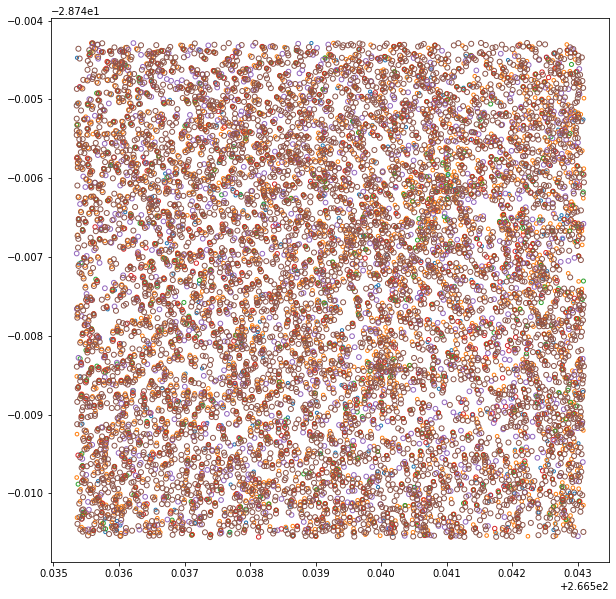

In [19]:
pl.figure(figsize=(10,10))
ax = pl.gca()
for ii, (ww, tbl) in enumerate(zip(wcses, tbls)):
    crds = tbl['skycoords']
    crds = crds[reg.contains(crds, ww)]
    markers = ax.scatter(crds.ra, crds.dec, s=10+3*ii)
    markers.set_edgecolors(markers.get_facecolors())
    markers.set_facecolors('none')
ax.axis()

In [20]:
tbls[0].meta['filter'], len(tbls[0])

('f410m', 72789)

In [21]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    basetable = tbls[0].copy()
    basecrds = basetable['skycoords']
    for colname in basetable.colnames:
        basetable.rename_column(colname, colname+"_"+basetable.meta['filter'])
    #basetable = basetable[[cn for cn in basetable.colnames if not any(x in cn for x in ignored_columns)]]

    for tbl in tbls[1:]:
        wl = tbl.meta['filter']
        print(wl)
        #tbl = tbl[[cn for cn in tbl.colnames if not any(x in cn for x in ignored_columns)]]
        crds = tbl['skycoords']
        matches, sep, _ = basecrds.match_to_catalog_sky(crds, nthneighbor=1)
        basetable.add_column(name=f"sep_{wl}", col=sep)
        basetable.add_column(name=f"id_{wl}", col=matches)
        matchtb = tbl[matches]
        for cn in matchtb.colnames:
            #matchtb[cn][sep > 0.1*u.arcsec].mask = True
            matchtb.rename_column(cn, f"{cn}_{wl}")
        basetable = table.hstack([basetable, matchtb], join_type='exact')
        basetable.meta[f'{wl}_pixelscale'] = tbl.meta['pixelscale']
        #if 'sky_centroid_f444w' in basetable.colnames:
        #    basetable.rename_column('sky_centroid_f444w', 'sky_centroid')
        #basetable = table.join(basetable, tbl,
        #                      table_names=['', wl],
        #                      join_type='outer',
        #                      join_funcs={'sky_centroid': table.join_skycoord(0.1*u.arcsec)})
        #if 'sky_centroid_' in basetable.colnames:
        #    basetable.rename_column('sky_centroid_', 'sky_centroid_f444w')
        basetable.write(f"{basepath}/catalogs/crowdsource_nrca_photometry_tables_merged.ecsv", overwrite=True)
        basetable.write(f"{basepath}/catalogs/crowdsource_nrca_photometry_tables_merged.fits", overwrite=True)

f212n
f466n
f405n
f187n
f182m


In [22]:
# Line-subtract the F410 continuum band
basetable.add_column(basetable['flux_jy_f410m'] - basetable['flux_jy_f405n'] * 0.16, name='flux_jy_410m405')
basetable.add_column(basetable['flux_jy_410m405'].to(u.ABmag), name='mag_ab_410m405')
# Then subtract that remainder back from the F405 band to get the continuum-subtracted F405
basetable.add_column(basetable['flux_jy_f405n'] - basetable['flux_jy_410m405'], name='flux_jy_405m410')
basetable.add_column(basetable['flux_jy_405m410'].to(u.ABmag), name='mag_ab_405m410')

basetable.write(f"{basepath}/catalogs/crowdsource_nrca_photometry_tables_merged.ecsv", overwrite=True)
basetable.write(f"{basepath}/catalogs/crowdsource_nrca_photometry_tables_merged.fits", overwrite=True)

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


0arcsec [0arcsec 0arcsec 0arcsec ... 0arcsec 0arcsec 0arcsec]
0arcsec
-0.0135495arcsec [0.100869arcsec -0.111919arcsec 0.245752arcsec ... 0.226537arcsec
 -0.0252701arcsec -0.00776848arcsec]
-0.00726897arcsec
-0.00261151arcsec [-0.112387arcsec -0.0637823arcsec -0.00439804arcsec ... 0.109417arcsec
 -0.0105502arcsec -0.0105862arcsec]
-0.00364604arcsec
-0.00244356arcsec [-0.0510287arcsec -0.0329771arcsec -0.00703799arcsec ... 0.134648arcsec
 0.0156498arcsec 0.0107913arcsec]
-0.0061292arcsec
0.00195114arcsec [0.228352arcsec 0.0928156arcsec -0.00595308arcsec ... 0.0702357arcsec
 -0.0866665arcsec 0.00445229arcsec]
0.000718716arcsec
0.00138544arcsec [0.0984917arcsec -0.0645719arcsec -0.0328165arcsec ... -0.0419252arcsec
 0.0113201arcsec 0.0878072arcsec]
-0.000394705arcsec


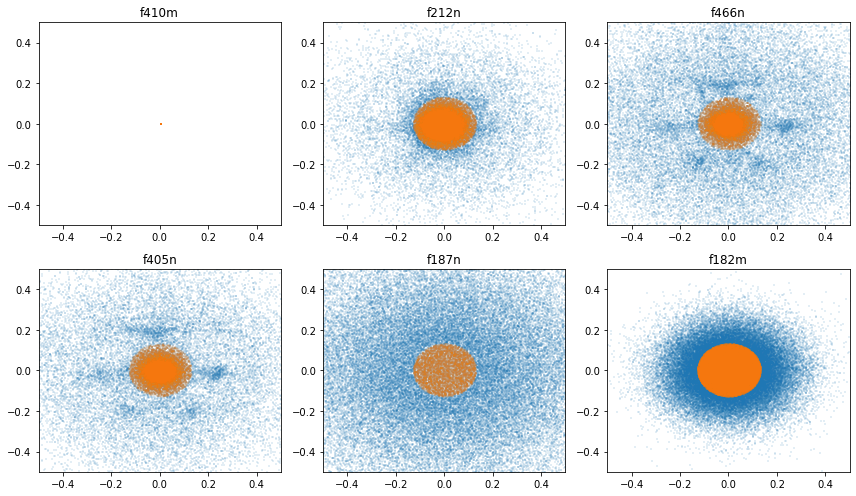

In [23]:
pl.figure(figsize=(12,7))
basecrds = basetable['skycoords_f410m']
ii = 1
for tbl in tbls:
    ax = pl.subplot(2,3,ii)
    filtername = tbl.meta['filter']
    #print(ii, filtername)
    crds = basetable[f'skycoords_{filtername}']
    radiff = (crds.ra-basecrds.ra).to(u.arcsec)
    decdiff = (crds.dec-basecrds.dec).to(u.arcsec)
    print(np.median(radiff), radiff[np.abs(radiff) < 0.25*u.arcsec])
    print(np.median(decdiff))
    ok = (radiff**2 + decdiff**2) < (0.13*u.arcsec)**2
    ax.scatter(radiff, decdiff, marker=',', s=1, alpha=0.1)
    ax.scatter(radiff[ok], decdiff[ok], marker=',', s=1, alpha=0.1)
    ax.axis([-0.5, 0.5, -0.5, 0.5])
    ax.set_title(filtername)
    ii += 1
pl.tight_layout()

In [24]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    basetable = Table.read(f"{basepath}/catalogs/crowdsource_nrca_photometry_tables_merged.ecsv")
    
    basecrds = basetable['skycoords_f410m']
    for tbl in tbls[1:]:
        wl = tbl.meta['filter']
        crds = basetable[f'skycoords_{wl}']
        radiff = (crds.ra-basecrds.ra).to(u.arcsec)
        decdiff = (crds.dec-basecrds.dec).to(u.arcsec)
        oksep = basetable[f'sep_{wl}'] < 0.25*u.arcsec
        medsep_ra, medsep_dec = np.median(radiff[oksep]), np.median(decdiff[oksep])
        print(wl, medsep_ra, medsep_dec)
        newcrds = SkyCoord(crds.ra - medsep_ra, crds.dec - medsep_dec, frame=crds.frame)
        basetable[f'skycoords_{wl}'] = newcrds
        matches, sep, _ = basecrds.match_to_catalog_sky(newcrds, nthneighbor=1)
        basetable[f"sep_{wl}"] = sep
        basetable[f"id_{wl}"] = matches
        basetable.write(f"{basepath}/catalogs/crowdsource_nrca_photometry_tables_merged_offsetcorrected.ecsv", overwrite=True)
        basetable.write(f"{basepath}/catalogs/crowdsource_nrca_photometry_tables_merged_offsetcorrected.fits", overwrite=True)

f212n -0.0136744arcsec -0.00730853arcsec
f466n -0.00256422arcsec -0.00367965arcsec
f405n -0.00243251arcsec -0.00615752arcsec
f187n -0.000104058arcsec 0.00091822arcsec
f182m 0.000745082arcsec -0.000571819arcsec


f212n 0.03715083882580758 arcsec 0.03187967537127971 arcsec
f466n 0.04028599303744997 arcsec 0.014408630263220677 arcsec
f405n 0.02370980282780776 arcsec 0.013382287938227872 arcsec
f187n 0.3739219367238802 arcsec 0.09029178928358601 arcsec
f182m 0.13529433945684513 arcsec 0.08603200014684716 arcsec


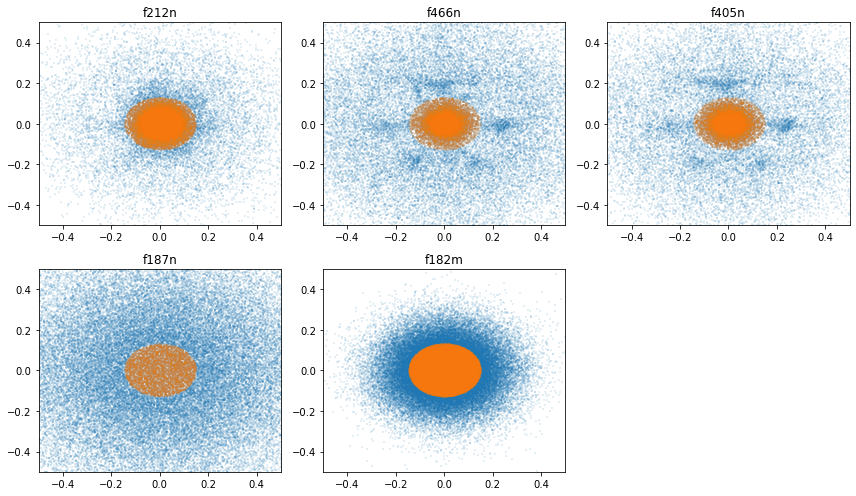

In [25]:
pl.figure(figsize=(12,7))
basecrds = basetable['skycoords_f410m']
ii = 1
for tbl in tbls[1:]:
    ax = pl.subplot(2,3,ii)
    filtername = tbl.meta['filter']
    #print(ii, filtername)
    crds = basetable[f'skycoords_{filtername}']
    radiff = (crds.ra-basecrds.ra).to(u.arcsec)
    decdiff = (crds.dec-basecrds.dec).to(u.arcsec)
    #print(np.median(radiff), radiff[np.abs(radiff) < 0.25*u.arcsec])
    #print(np.median(decdiff))
    sep = basetable[f'sep_{filtername}']
    print(filtername, np.median(sep.to(u.arcsec)), np.median(sep[sep<0.13*u.arcsec].to(u.arcsec)))
    ok = sep < (0.13*u.arcsec)
    ax.scatter(radiff, decdiff, marker=',', s=1, alpha=0.1)
    ax.scatter(radiff[ok], decdiff[ok], marker=',', s=1, alpha=0.1)
    ax.axis([-0.5, 0.5, -0.5, 0.5])
    ax.set_title(filtername)
    ii += 1
pl.tight_layout()

In [26]:
len(basetable)

72789

In [27]:
basetable[reg.contains(basetable['skycoords_f405n'],ww)][:5]

<Table length=5>
     x_f410m            y_f410m       flux_f410m passno_f410m   dx_f410m     dy_f410m  dflux_f410m ...            skycoords_f182m             flux_jy_f182m mag_ab_f182m flux_jy_410m405 mag_ab_410m405 flux_jy_405m410 mag_ab_405m410
                                                                                                   ...                deg,deg                       Jy        mag(AB)           Jy          mag(AB)            Jy          mag(AB)    
     float64            float64        float32     float64      float32      float32     float32   ...                SkyCoord                   float32      float32        float32        float32         float32        float32    
------------------ ------------------ ---------- ------------ ------------ ----------- ----------- ... -------------------------------------- ------------- ------------ --------------- -------------- --------------- --------------
 790.1026324907541 1123.0283490253605   94.64558          0.0 0.0142646935 0.014274441   0.7824822 ... 266.53537066595476,-28.748665302956667 7.2068788e-06     21.75563      6.4078e-05      19.383228   0.00014402432       18.50391
1011.7470735552789 1122.6137105803436  37.918087          0.0  0.025824612 0.023819502   0.5488399 ...  266.53531133870086,-28.74475666386962 2.5804247e-05    20.370771   3.9196715e-05      19.916876   -4.004067e-05            nan
 740.9767233589365  1124.145785714267   44.83494          0.0  0.029302552 0.030069023   0.7514844 ...   266.5354067787196,-28.74954246899511   1.73356e-05    20.802652   4.9154685e-05      19.671087   -6.805071e-05            nan
 797.4164326477837 1124.5810095777715  19.939564          0.0  0.060938668  0.05940162   0.6422365 ...   266.5354092326894,-28.74852625366104 1.2922525e-06    23.621632  -2.6119833e-06            nan   0.00014753683      18.477749
 695.4374094982351 1124.2016303263028  51.894882          0.0  0.026845545 0.026061364  0.73351824 ... 266.53543374244424,-28.750317768712478  3.129539e-05      20.1613   5.8158334e-05       19.48847  -8.7031425e-05            nan

In [28]:
basetable[reg.contains(basetable['skycoords_f410m'],ww)][:5]['flux_f410m', 'skycoords_f410m', 'x_f410m', 'y_f410m']

<Table length=5>
flux_f410m            skycoords_f410m                  x_f410m           y_f410m      
                          deg,deg                                                     
 float32                  SkyCoord                     float64           float64      
---------- -------------------------------------- ----------------- ------------------
  94.64558    266.5353728384413,-28.7486424757595 790.1026324907541 1123.0283490253605
 89.488655 266.53536747563004,-28.747635692108197 847.7150957324101 1123.7151886941112
  44.83494 266.53541135108117,-28.749500462269094 740.9767233589365  1124.145785714267
 19.939564   266.5354013614493,-28.74851424151182 797.4164326477837 1124.5810095777715
 51.894882   266.5354275225895,-28.75029609281209 695.4374094982351 1124.2016303263028

In [29]:
#(500*u.Jy).to(u.ABmag)
(basetable[reg.contains(basetable['skycoords_f410m'],ww)][:5]['flux_f410m'] * u.Jy).to(u.ABmag)

<Magnitude [3.959749 , 4.0205803, 4.7709584, 5.650711 , 4.612189 ] mag(AB)>

In [30]:
tbls[5][20:30]

<Table length=10>
        x                  y             flux    passno      dx           dy        dflux   ...  fluxiso           xiso                  yiso             sky                  skycoords                   flux_jy      mag_ab 
                                                                                            ...                                                                                 deg,deg                       Jy       mag(AB) 
     float64            float64        float32  float64   float32      float32     float32  ...  float32         float64               float64          float32                 SkyCoord                   float32     float32 
------------------ ------------------ --------- ------- ------------ ------------ --------- ... --------- --------------------- ---------------------- --------- -------------------------------------- ------------- ---------
2641.5875433130523  4.717426401543116 181.38853     0.0   0.01971635  0.027130418 2.9231734 ... 183.14572    0.0756873822238078  -0.056477141733342284  5.503011  266.5123575388837,-28.740599833047728 3.1717973e-05 20.146736
 2648.993869065861  4.868599814003886 445.28543     0.0  0.008649209  0.011107602 2.9513516 ...  445.6873   0.01347249866323443  -0.014167253209863602  5.469206 266.51235801578827,-28.740536217863138 7.7231154e-05  19.18052
 2697.923723896721  5.045144198453229  86.14943     0.0  0.048642043  0.057669155 2.9709356 ...  85.99001 -0.057677108128972684 -0.0038823464546877116 5.2325687  266.5123531145493,-28.740116042141644 1.4937386e-05 20.964314
2720.9094245165816  4.918849241471443 3017.1494     0.0 0.0011888408 0.0016422719 2.9517255 ... 3004.9944  -0.11751187618399285 -4.841085463989979e-06 5.1257377  266.5123487630637,-28.739918681715192  0.0005233174 17.103086
2740.4159079842257 4.6194478277503865 90.483826     0.0  0.037608285  0.053623505  2.880401 ...   92.1204   0.10654689609964217    0.03803485295962824 5.0877256  266.51234318775596,-28.73975121747235 1.5834508e-05  20.90099
 2764.140912744765  4.929258672904215 493.40726     0.0  0.008046982  0.010054751 2.9611616 ...  495.6648   0.08732827794505386   0.013188587331356394 5.0397105  266.51234300702794,-28.73954745691652  8.560418e-05 19.068762
2785.2542794466904  4.373813283445608  43.67581     0.0   0.06977985  0.103570834 2.6914876 ... 48.070576   0.30847423618287884   -0.15033235756974236 4.9976974 266.51233470651164,-28.739366224981794  7.626199e-06  21.69423
 2789.891146875888  3.723322445339796 14.806153     0.0   0.18662685   0.21467154 1.9068778 ... 23.041388    0.9332955749610338   -0.11038137183914702 4.9876943   266.5123277077937,-28.73932648604612 2.5756947e-06 22.872765
2805.6728705842465  4.697593252215558 54.392696     0.0  0.065050475   0.09015293   2.91414 ...  54.88173    0.0653060174605871   0.054314646029767606  4.955684  266.5123351106259,-28.739190854540226  9.502593e-06 21.455395
 2810.548084289641  4.841897974695884  72.18062     0.0    0.0528046   0.06885956 2.9560113 ...  71.85773   -0.0638762953711702   0.022888937436773612  4.945681   266.5123358632391,-28.73914897452478  1.260054e-05 21.149027

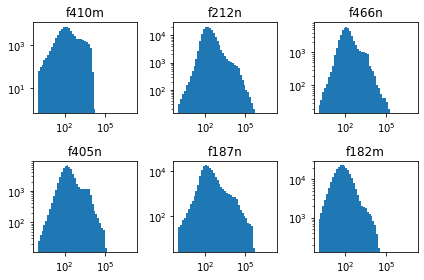

In [31]:
for ii, tbl in enumerate(tbls):
    ax = pl.subplot(2,3,ii+1)
    ax.hist(tbl['flux'], bins=np.logspace(0,7), log=True)
    ax.set_title(tbl.meta['filter'])
    ax.loglog()
pl.tight_layout()

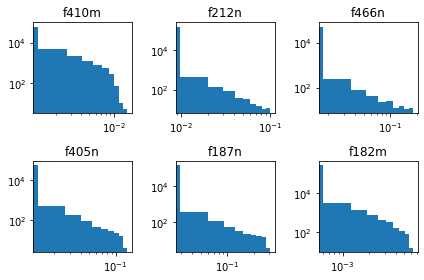

In [32]:
for ii, tbl in enumerate(tbls):
    ax = pl.subplot(2,3,ii+1)
    ax.hist(tbl['flux_jy'], log=True)
    ax.set_title(tbl.meta['filter'])
    ax.loglog()
pl.tight_layout()

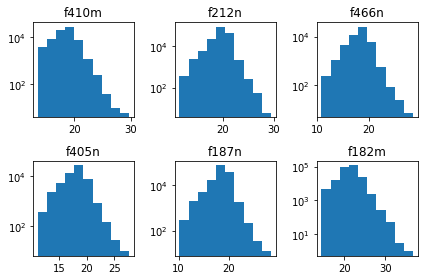

In [33]:
for ii, tbl in enumerate(tbls):
    ax = pl.subplot(2,3,ii+1)
    ax.hist(tbl['mag_ab'], log=True)
    ax.set_title(tbl.meta['filter'])
    #ax.loglog()
pl.tight_layout()

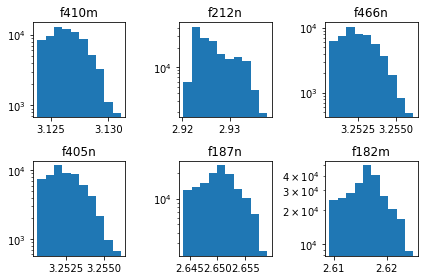

In [34]:
for ii, tbl in enumerate(tbls):
    ax = pl.subplot(2,3,ii+1)
    ax.hist(tbl['fwhm'], log=True)
    ax.set_title(tbl.meta['filter'])
pl.tight_layout()

# XMatch Check

In [35]:
len(tbls[0]), tbls[0].meta['filter']

(72789, 'f410m')

In [36]:
fh = fits.open(f'{basepath}/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits')
ww410 = wcs.WCS(fh[1].header)

Set OBSGEO-B to   -20.633936 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526083300.815 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


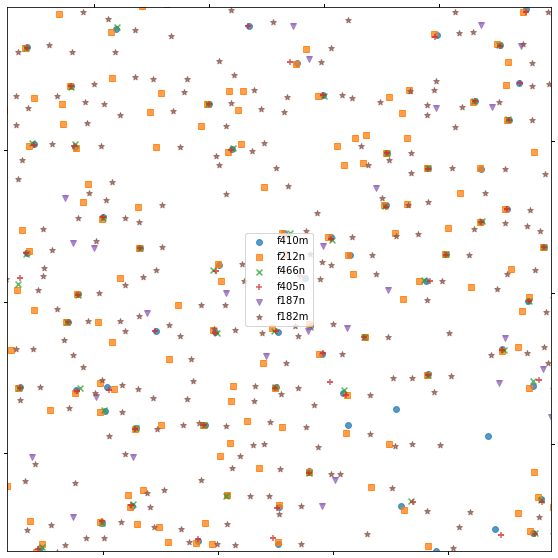

In [37]:
pl.figure(figsize=(10,10))
ax = pl.subplot(projection=ww410)
data410 = imgs[0]
ax.imshow(data410)
for tbl,marker in zip(tbls, 'osx+v*'):
    crds = tbl['skycoords']
    pl.scatter(crds.ra, crds.dec, alpha=0.75, s=35,
               marker=marker, label=tbl.meta['filter'])
pl.axis((266.5385, 266.54, -28.740, -28.7385))
pl.legend(loc='best')

# Color-magnitude and color-color diagrams

(25.0, 13.0)

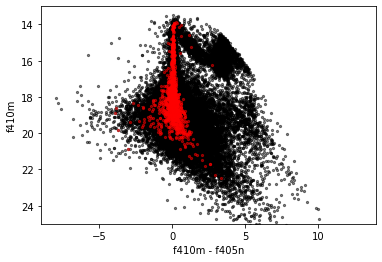

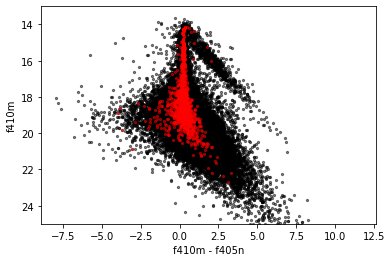

In [38]:
sel = reg.contains(basetable['skycoords_f410m'], ww)
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
pl.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f405n'], basetable['mag_ab_f410m'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f405n'])[sel], basetable['mag_ab_f410m'][sel], s=5, alpha=0.5, c='r')
pl.ylim(pl.ylim()[::-1])
pl.xlabel("f410m - f405n")
pl.ylabel("f410m")
pl.ylim(25,13)

pl.figure()
pl.scatter(basetable['mag_ab_410m405'] - basetable['mag_ab_f405n'], basetable['mag_ab_410m405'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_410m405'] - basetable['mag_ab_f405n'])[sel], basetable['mag_ab_410m405'][sel], s=5, alpha=0.5, c='r')
pl.ylim(pl.ylim()[::-1])
pl.xlabel("f410m - f405n")
pl.ylabel("f410m")
pl.ylim(25,13)

(25.0, 14.0)

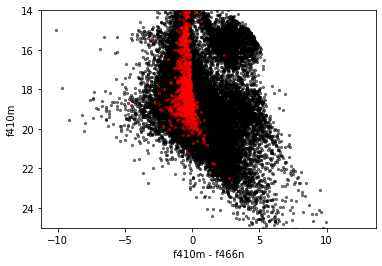

In [39]:
sel = reg.contains(basetable['skycoords_f410m'], ww)
sel &= basetable['sep_f466n'].quantity < 0.1*u.arcsec
pl.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'], basetable['mag_ab_f410m'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'])[sel], basetable['mag_ab_f410m'][sel], s=5, alpha=0.5, c='r')
pl.ylim(pl.ylim()[::-1])
pl.xlabel("f410m - f466n")
pl.ylabel("f410m")
pl.ylim(25,14)

(-5.0, 10.0, -5.0, 10.0)

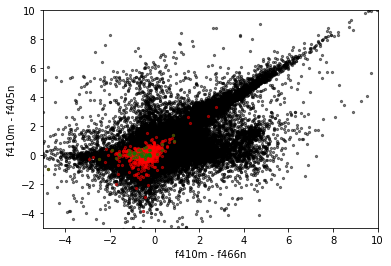

In [40]:
sel = reg.contains(basetable['skycoords_f410m'], ww)
sel &= basetable['sep_f466n'].quantity < 0.1*u.arcsec
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
sel2 = regzoom.contains(basetable['skycoords_f410m'], ww)
sel2 &= basetable['sep_f466n'].quantity < 0.1*u.arcsec
sel2 &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
pl.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'], basetable['mag_ab_f410m']-basetable['mag_ab_f405n'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'])[sel], (basetable['mag_ab_f410m']-basetable['mag_ab_f405n'])[sel], s=5, alpha=0.5, c='r')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'])[sel2], (basetable['mag_ab_f410m']-basetable['mag_ab_f405n'])[sel2], s=5, alpha=0.5, c='g')
pl.ylim(pl.ylim()[::-1])
pl.xlabel("f410m - f466n")
pl.ylabel("f410m - f405n")
pl.axis((-5,10,-5,10))

(-5.0, 10.0, -5.0, 10.0)

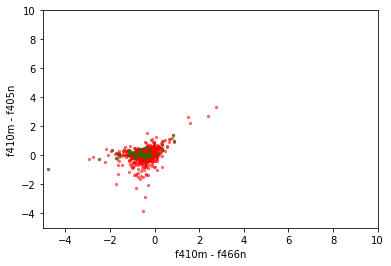

In [41]:
sel = reg.contains(basetable['skycoords_f410m'], ww)
sel &= basetable['sep_f466n'].quantity < 0.1*u.arcsec
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
sel2 = regzoom.contains(basetable['skycoords_f410m'], ww)
sel2 &= basetable['sep_f466n'].quantity < 0.1*u.arcsec
sel2 &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
#pl.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'], basetable['mag_ab_f410m']-basetable['mag_ab_f405n'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'])[sel], (basetable['mag_ab_f410m']-basetable['mag_ab_f405n'])[sel], s=5, alpha=0.5, c='r')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'])[sel2], (basetable['mag_ab_f410m']-basetable['mag_ab_f405n'])[sel2], s=5, alpha=0.5, c='g')
pl.ylim(pl.ylim()[::-1])
pl.xlabel("f410m - f466n")
pl.ylabel("f410m - f405n")
pl.axis((-5,10,-5,10))

(-5.0, 10.0, -5.0, 10.0)

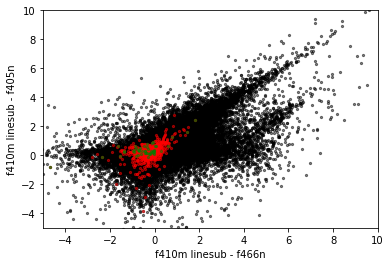

In [42]:
sel = reg.contains(basetable['skycoords_f410m'], ww)
sel &= basetable['sep_f466n'].quantity < 0.1*u.arcsec
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
sel2 = regzoom.contains(basetable['skycoords_f410m'], ww)
sel2 &= basetable['sep_f466n'].quantity < 0.1*u.arcsec
sel2 &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
pl.scatter(basetable['mag_ab_410m405'] - basetable['mag_ab_f466n'], basetable['mag_ab_410m405']-basetable['mag_ab_f405n'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_410m405'] - basetable['mag_ab_f466n'])[sel], (basetable['mag_ab_410m405']-basetable['mag_ab_f405n'])[sel], s=5, alpha=0.5, c='r')
pl.scatter((basetable['mag_ab_410m405'] - basetable['mag_ab_f466n'])[sel2], (basetable['mag_ab_410m405']-basetable['mag_ab_f405n'])[sel2], s=5, alpha=0.5, c='g')
pl.ylim(pl.ylim()[::-1])
pl.xlabel("f410m linesub - f466n")
pl.ylabel("f410m linesub - f405n")
pl.axis((-5,10,-5,10))

(25.0, 14.0)

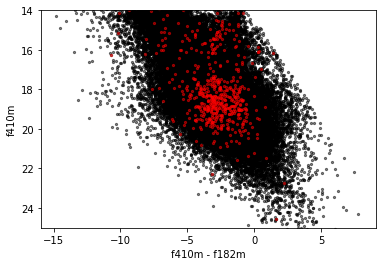

In [43]:
sel = reg.contains(basetable['skycoords_f410m'], ww)
sel &= basetable['sep_f182m'].quantity < 0.1*u.arcsec
pl.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f182m'], basetable['mag_ab_f410m'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f182m'])[sel], basetable['mag_ab_f410m'][sel], s=5, alpha=0.5, c='r')
pl.xlabel("f410m - f182m")
pl.ylabel("f410m")
pl.ylim(25,14)

(25.0, 14.0)

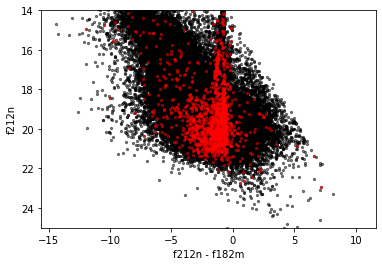

In [44]:
sel = reg.contains(basetable['skycoords_f212n'], ww)
pl.scatter(basetable['mag_ab_f212n'] - basetable['mag_ab_f182m'], basetable['mag_ab_f212n'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_f212n'] - basetable['mag_ab_f182m'])[sel], basetable['mag_ab_f212n'][sel], s=5, alpha=0.5, c='r')
pl.ylim(pl.ylim()[::-1])
pl.xlabel("f212n - f182m")
pl.ylabel("f212n")
pl.ylim(25,14)

0arcsec [0arcsec 0arcsec 0arcsec ... 0arcsec 0arcsec 0arcsec]
0arcsec
0.000124937arcsec [0.114544arcsec -0.0982449arcsec -0.0308372arcsec ... 0.240211arcsec
 -0.0115957arcsec 0.00590597arcsec]
3.95598e-05arcsec
-4.72921e-05arcsec [-0.109823arcsec -0.0612181arcsec -0.00183382arcsec ... 0.111981arcsec
 -0.00798594arcsec -0.00802194arcsec]
3.36075e-05arcsec
-1.10424e-05arcsec [-0.0485962arcsec -0.0305445arcsec -0.00460547arcsec ... 0.13708arcsec
 0.0180823arcsec 0.0132238arcsec]
2.83149e-05arcsec
0.00205519arcsec [0.228456arcsec 0.0929197arcsec -0.00584902arcsec ... 0.0703397arcsec
 -0.0865624arcsec 0.00455635arcsec]
-0.000199504arcsec
0.00064036arcsec [0.0977466arcsec -0.065317arcsec -0.0335616arcsec ... -0.0426702arcsec
 0.0105751arcsec 0.0870621arcsec]
0.000177114arcsec


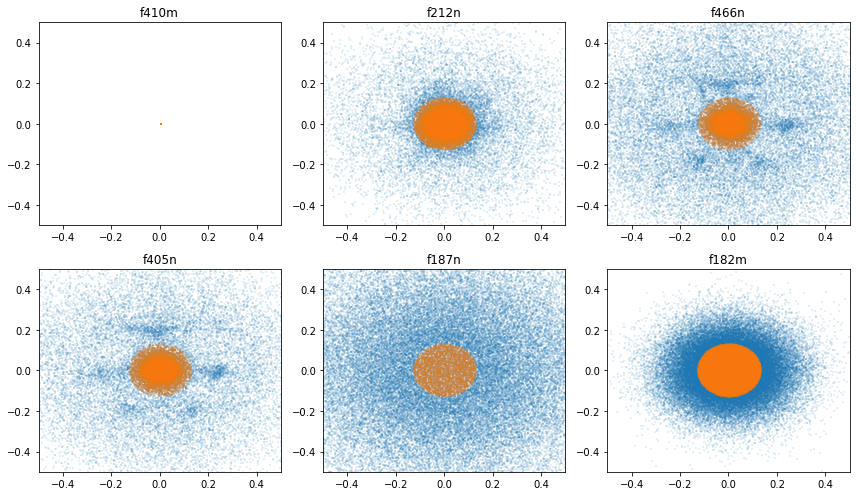

In [45]:
pl.figure(figsize=(12,7))
basecrds = basetable['skycoords_f410m']
ii = 1
for tbl in tbls:
    ax = pl.subplot(2,3,ii)
    filtername = tbl.meta['filter']
    #print(ii, filtername)
    crds = basetable[f'skycoords_{filtername}']
    radiff = (crds.ra-basecrds.ra).to(u.arcsec)
    decdiff = (crds.dec-basecrds.dec).to(u.arcsec)
    print(np.median(radiff), radiff[np.abs(radiff) < 0.25*u.arcsec])
    print(np.median(decdiff))
    ok = (radiff**2 + decdiff**2) < (0.13*u.arcsec)**2
    ax.scatter(radiff, decdiff, marker=',', s=1, alpha=0.1)
    ax.scatter(radiff[ok], decdiff[ok], marker=',', s=1, alpha=0.1)
    ax.axis([-0.5, 0.5, -0.5, 0.5])
    ax.set_title(filtername)
    ii += 1
pl.tight_layout()

In [46]:
import PIL
import pyavm

In [47]:
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickJWST_longwave_RGB_unrotated.png')
img = np.array(PIL.Image.open(f'{basepath}/images/BrickJWST_longwave_RGB_unrotated.png'))[::-1,:,:]
#wwi = avm.to_wcs(use_full_header=True)
wwi = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

Set DATE-AVG to '2022-08-28T03:05:32.473' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.651775 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526292809.682 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [48]:
# This image shows "CO-absorbed" stars as purple
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickJWST_nrca_longwave_stars_rotated.png')
img = np.array(PIL.Image.open(f'{basepath}/images/BrickJWST_nrca_longwave_stars_rotated.png'))[::-1,:,:]
#wwi = avm.to_wcs(use_full_header=True)
wwi = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

Set OBSGEO-B to   -20.633936 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526083300.815 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [49]:
wwi

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 266.53558384928  -28.737314463763  
CRPIX : 1439.2536406274  1145.460811606  
PC1_1 PC1_2  : -0.01659228901694  0.99986233849724  
PC2_1 PC2_2  : 0.99986233849724  0.01659228901694  
CDELT : 1.7474051110355e-05  1.7474051110355e-05  
NAXIS : 2901  2296

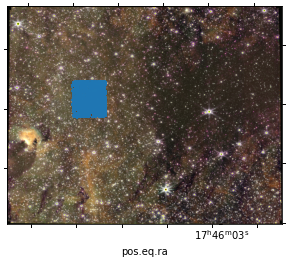

In [50]:
ax = pl.subplot(projection=wwi)
ax.imshow(img)
crds = basetable['skycoords_f410m']
ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('fk5'), marker=',', s=1)

In [51]:
reg

<RectangleSkyRegion(center=<SkyCoord (ICRS): (ra, dec) in deg
    (266.53922457, -28.74741879)>, width=24.436 arcsec, height=22.5714 arcsec, angle=0.0 deg)>

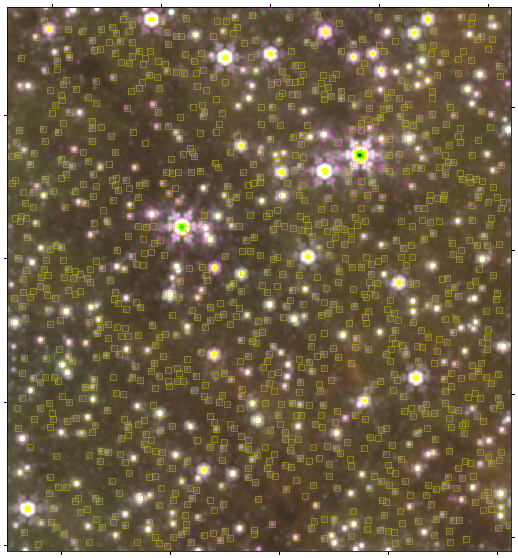

In [52]:
mask = reg.to_pixel(wwi).to_mask()
slcs,_ = mask.get_overlap_slices(img.shape[:2])
#co = np.array([mask.cutout(img[:,:,ii]) for ii in range(img.shape[2])])
co = img[slcs[0], slcs[1], :]

pl.figure(figsize=(10,10))
ax = pl.subplot(projection=wwi[slcs])
pl.imshow(co)

crds = basetable['skycoords_f410m']
sel = reg.contains(crds, ww410)
xx,yy = ww410[slcs].world_to_pixel(crds[sel])

colorby = basetable['flux_f410m']
colorby = basetable['mag_ab_f410m'] - basetable['mag_ab_f405n']
#sel = sel & (colorby > 2)
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec

scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'),
                  edgecolor='y', facecolor='none', marker='s',
                  alpha=0.5)#r'$\rightarrow$')
                  #c=colorby[sel],
                  #norm=simple_norm(colorby[sel], stretch='linear',), cmap='jet')
#pl.draw()
#colors = scat.get_facecolors()
#scat.set_edgecolors(colors)
#scat.set_facecolors('none')

(25.0, 14.0)

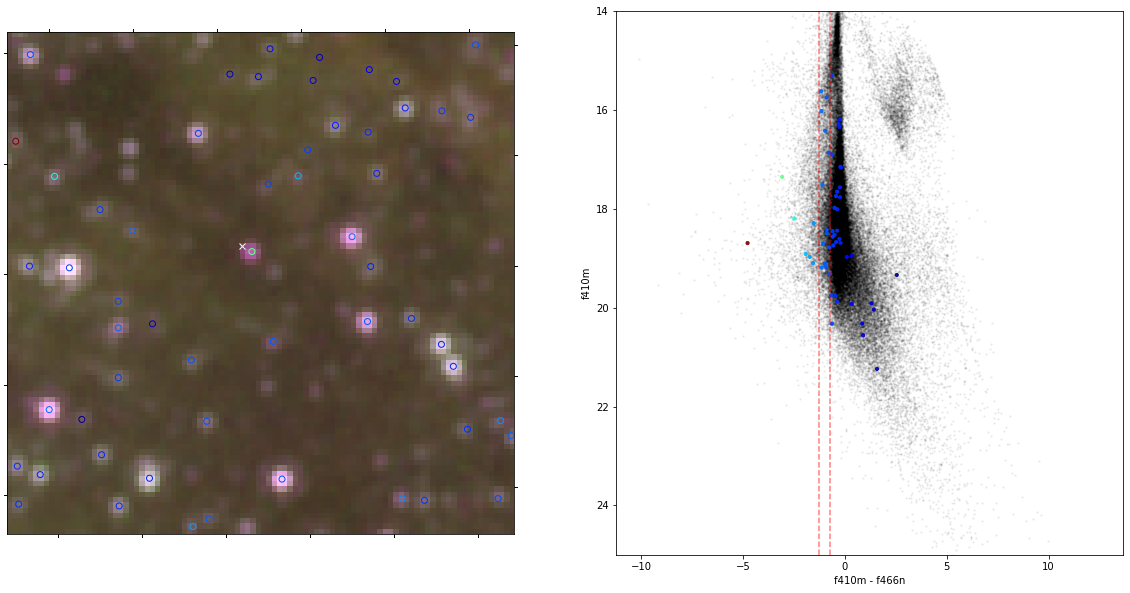

In [53]:
mask = regzoom.to_pixel(wwi).to_mask()
slcs,_ = mask.get_overlap_slices(img.shape[:2])
#co = np.array([mask.cutout(img[:,:,ii]) for ii in range(img.shape[2])])
co = img[slcs[0], slcs[1], :]

pl.figure(figsize=(20,10))
ax = pl.subplot(1,2,1, projection=wwi[slcs])
pl.imshow(co)

crds = basetable['skycoords_f410m']
sel = regzoom.contains(crds, ww410)
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
xx,yy = ww410[slcs].world_to_pixel(crds[sel])

colorby = basetable['flux_f410m']
colorby = basetable['mag_ab_f410m'] - basetable['mag_ab_f405n']
colorby = basetable['mag_ab_f410m'] - basetable['mag_ab_f466n']
#sel = sel & (colorby < -2)

scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'),
                  #edgecolor='r', facecolor='none', marker='s')#r'$\rightarrow$')
                  c=colorby[sel],
                  norm=simple_norm(colorby[sel], stretch='asinh',), cmap='jet_r')
pl.draw()
colors = scat.get_facecolors()
scat.set_edgecolors(colors)
scat.set_facecolors('none')
#pl.colorbar(mappable=scat)
ax.axis()
pl.plot(44,54, 'wx')
wwi[slcs].pixel_to_world(45,55)

ax2 = pl.subplot(1,2,2)
ax2.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'], basetable['mag_ab_f410m'], s=2, alpha=0.05, c='k')
ax2.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'])[sel], basetable['mag_ab_f410m'][sel], s=10, alpha=0.9,
            c=colorby[sel],
            norm=simple_norm(colorby[sel], stretch='asinh',), cmap='jet_r'
           )
ax2.axvline(-0.75, linestyle='--', color='r', alpha=0.5)
ax2.axvline(-1.25, linestyle='--', color='r', alpha=0.5)
ax2.set_ylim(pl.ylim()[::-1])
ax2.set_xlabel("f410m - f466n")
ax2.set_ylabel("f410m")
ax2.set_ylim(25,14)

Set OBSGEO-B to   -20.633936 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526083300.815 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


(25.0, 14.0)

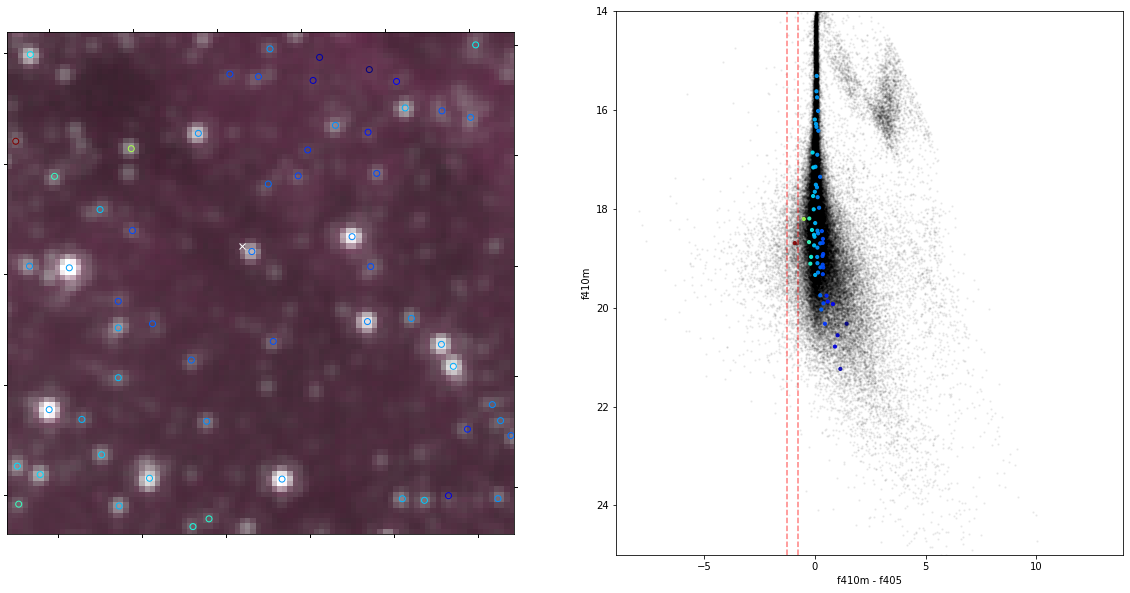

In [54]:
# This image shows only H-alpha stars
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickJWST_nrca_longwave_stars_bra_410.png')
img_bra_410 = np.array(PIL.Image.open(f'{basepath}/images/BrickJWST_nrca_longwave_stars_bra_410.png'))[::-1,:,:]
#wwi_bra_410 = avm.to_wcs(use_full_header=True)
wwi_bra_410 = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

mask = regzoom.to_pixel(wwi_bra_410).to_mask()
slcs,_ = mask.get_overlap_slices(img_bra_410.shape[:2])
#co = np.array([mask.cutout(img_bra_410[:,:,ii]) for ii in range(img_bra_410.shape[2])])
co = img_bra_410[slcs[0], slcs[1], :]

pl.figure(figsize=(20,10))
ax = pl.subplot(1,2,1, projection=wwi_bra_410[slcs])
pl.imshow(co)

crds = basetable['skycoords_f410m']
sel = regzoom.contains(crds, ww410)
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
xx,yy = ww410[slcs].world_to_pixel(crds[sel])

colorby = basetable['flux_f410m']
colorby = basetable['mag_ab_f410m'] - basetable['mag_ab_f405n']
#sel = sel & (colorby < -2)

scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'),
                  #edgecolor='r', facecolor='none', marker='s')#r'$\rightarrow$')
                  c=colorby[sel],
                  norm=simple_norm(colorby[sel], stretch='asinh',), cmap='jet_r')
pl.draw()
colors = scat.get_facecolors()
scat.set_edgecolors(colors)
scat.set_facecolors('none')
#pl.colorbar(mappable=scat)
ax.axis()
pl.plot(44,54, 'wx')
wwi_bra_410[slcs].pixel_to_world(45,55)

ax2 = pl.subplot(1,2,2)
ax2.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f405n'], basetable['mag_ab_f410m'], s=2, alpha=0.05, c='k')
ax2.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f405n'])[sel], basetable['mag_ab_f410m'][sel], s=10, alpha=0.9,
            c=colorby[sel],
            norm=simple_norm(colorby[sel], stretch='asinh',), cmap='jet_r'
           )
ax2.axvline(-0.75, linestyle='--', color='r', alpha=0.5)
ax2.axvline(-1.25, linestyle='--', color='r', alpha=0.5)
ax2.set_ylim(pl.ylim()[::-1])
ax2.set_xlabel("f410m - f405")
ax2.set_ylabel("f410m")
ax2.set_ylim(25,14)

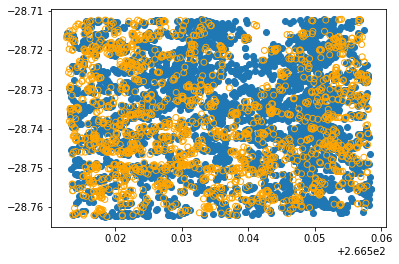

In [55]:
blue_410_466 = (basetable['mag_ab_f410m'] - basetable['mag_ab_f466n']) < -1.25
pl.scatter(crds.ra[blue_410_466], crds.dec[blue_410_466])
blue_410_405 = (basetable['mag_ab_f410m'] - basetable['mag_ab_f405n']) < -1.00
pl.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none')

In [56]:
import warnings

In [57]:
def starzoom(coords):
    reg = regions.RectangleSkyRegion(center=coords, width=1*u.arcsec, height=1*u.arcsec)
    ii = 0
    pl.figure(figsize=(12,4))
    filters_plotted = []
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for fn in sorted(glob.glob(f'{basepath}/F*/pipeline/*nircam*nrc*_i2d.fits')):
            filtername = fits.getheader(fn)['PUPIL']+fits.getheader(fn)['FILTER']
            if filtername in filters_plotted:
                continue
            ww = wcs.WCS(fits.getheader(fn, ext=('SCI',1)))
            if ww.footprint_contains(coords):
                print(fn)
                data = fits.getdata(fn, ext=('SCI',1))
                mask = reg.to_pixel(ww).to_mask()
                slcs,_ = mask.get_overlap_slices(data.shape)
                ax = pl.subplot(1,6,ii+1)
                ax.imshow(data[slcs], norm=simple_norm(data[slcs], stretch='asinh'),
                          origin='lower', cmap='gray')
                xx, yy = ww[slcs].world_to_pixel(coords)
                ax.plot(xx, yy, 'rx')
                ax.set_title(filtername)
                filters_plotted.append(filtername)
                ii += 1

/orange/adamginsburg/jwst/brick/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrca_i2d.fits


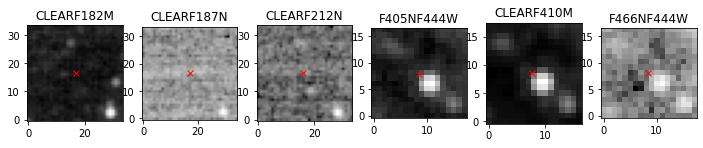

In [58]:
starzoom(coordinates.SkyCoord(266.54177, -28.74910, unit=(u.deg, u.deg), frame='icrs'))

/orange/adamginsburg/jwst/brick/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrca_i2d.fits


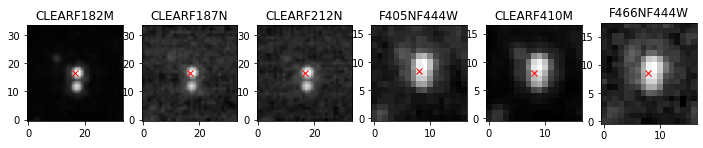

In [59]:
starzoom(coordinates.SkyCoord("17:46:10.006 -28:44:21.00", unit=(u.hour, u.deg), frame='icrs'))

/orange/adamginsburg/jwst/brick/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrcb3_i2d.fits
/orange/adamginsburg/jwst/brick/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrcb3_i2d.fits
/orange/adamginsburg/jwst/brick/F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrcb3_i2d.fits
/orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrcb_i2d.fits
/orange/adamginsburg/jwst/brick/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrcb_i2d.fits
/orange/adamginsburg/jwst/brick/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrcb_i2d.fits


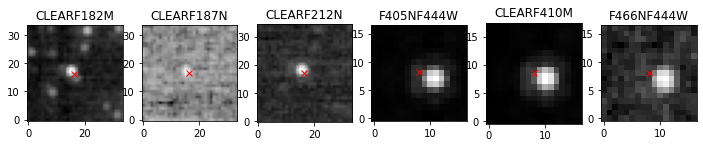

In [60]:
starzoom(coordinates.SkyCoord("17:46:10.682 -28:42:23.87", unit=(u.hour, u.deg), frame='icrs'))

/orange/adamginsburg/jwst/brick/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrca_i2d.fits


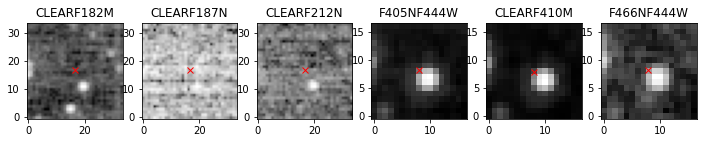

In [61]:
starzoom(coordinates.SkyCoord("17:46:09.310 -28:44:08.95", unit=(u.hour, u.deg), frame='icrs'))

/orange/adamginsburg/jwst/brick/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrca_i2d.fits


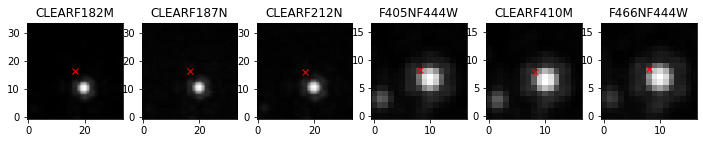

In [62]:
starzoom(coordinates.SkyCoord("17:46:09.256 -28:44:11.15", unit=(u.hour, u.deg), frame='icrs'))

/orange/adamginsburg/jwst/brick/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrca3_i2d.fits
/orange/adamginsburg/jwst/brick/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrca3_i2d.fits
/orange/adamginsburg/jwst/brick/F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrca3_i2d.fits
/orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrca_i2d.fits


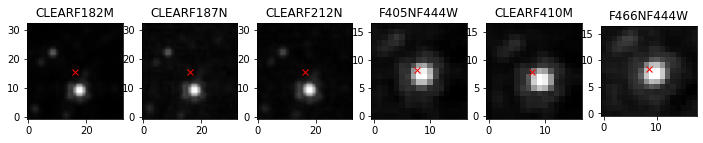

In [63]:
starzoom(coordinates.SkyCoord("17:46:03.833 -28:42:59.76", unit=(u.hour, u.deg), frame='icrs'))

/orange/adamginsburg/jwst/brick/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrca1-test_i2d.fits
/orange/adamginsburg/jwst/brick/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrca1_i2d.fits
/orange/adamginsburg/jwst/brick/F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrca1_i2d.fits
/orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrca_i2d.fits


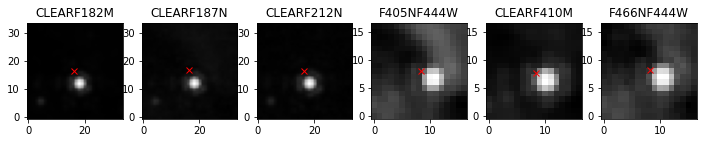

In [64]:
starzoom(coordinates.SkyCoord("17:46:07.378 -28:45:29.38", unit=(u.hour, u.deg), frame='icrs'))

In [65]:
ww410

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 266.5355853331  -28.7373131032  
CRPIX : 1439.1905889542  1145.4462078889  
PC1_1 PC1_2  : -0.01659228901694  0.99986233849724  
PC2_1 PC2_2  : 0.99986233849724  0.01659228901694  
CDELT : 1.7474051110355e-05  1.7474051110355e-05  
NAXIS : 2901  2296

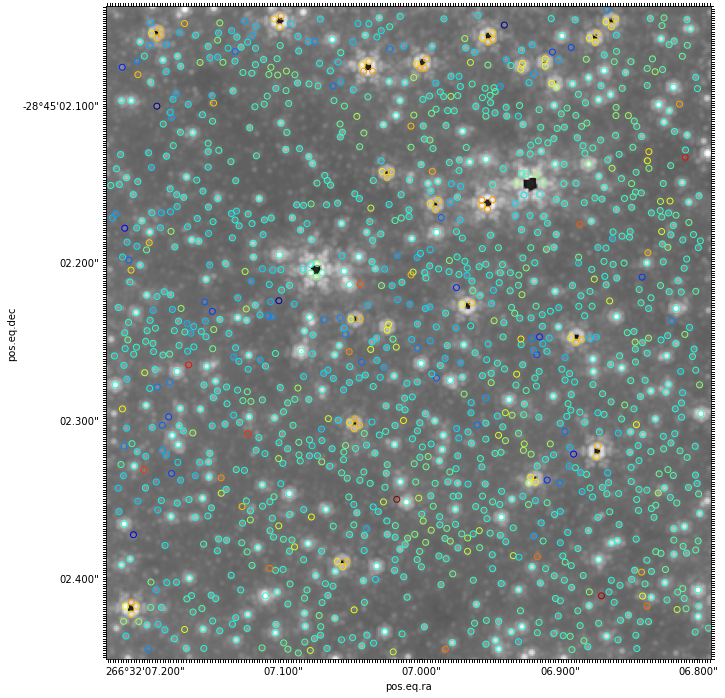

In [66]:
pl.figure(figsize=(12,12))
mask = reg.to_pixel(ww410).to_mask()
slcs,_ = mask.get_overlap_slices(fh['SCI'].data.shape)
ax = pl.subplot(projection=ww410[slcs])
co = mask.cutout(fh['SCI'].data)
co = fh['SCI'].data[slcs]
ax.imshow(co, cmap='gray', norm=simple_norm(co, stretch='log', max_percent=99.95), origin='lower')
crds = basetable['skycoords_f410m']
sel = reg.contains(crds, ww410)
xx,yy = ww410[slcs].world_to_pixel(crds[sel])

colorby = basetable['flux_f410m']
colorby = basetable['mag_ab_f410m'] - basetable['mag_ab_f405n']

scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'),
                  c=colorby[sel],
                  norm=simple_norm(colorby[sel], stretch='linear',), cmap='jet')
pl.draw()
colors = scat.get_facecolors()
scat.set_edgecolors(colors)
scat.set_facecolors('none')

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss.sss')
lat.set_major_formatter('dd:mm:ss.sss')
lon.set_ticks(spacing=0.1 * u.arcsec)
lat.set_ticks(spacing=0.1 * u.arcsec)

In [67]:
tbls[0].meta

OrderedDict([('filename',
              '/orange/adamginsburg/jwst/brick//F410M/f410m_nrca_crowdsource.fits'),
             ('filter', 'f410m'),
             ('pixelscale', <Quantity 3.05342462e-10 deg2>)])

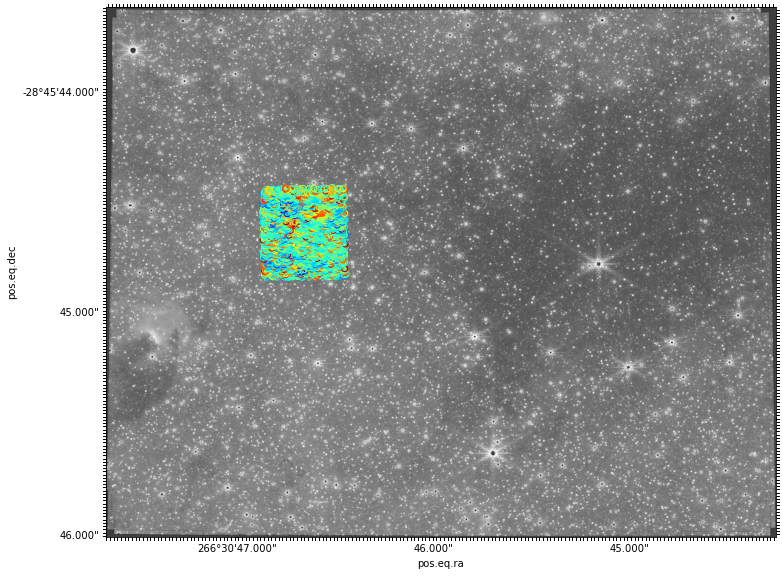

In [68]:
pl.figure(figsize=(12,12))
mask = reg.to_pixel(ww410).to_mask()
slcs,_ = mask.get_overlap_slices(fh['SCI'].data.shape)
ax = pl.subplot(projection=ww410)
#ax = pl.gca()
co = fh['SCI'].data
ax.imshow(co, cmap='gray', norm=simple_norm(co, stretch='log', max_percent=99.95), origin='lower')
crds = basetable['skycoords_f410m']
#crds = tbls[0]['skycoords']
sel = reg.contains(crds, ww410)
xx,yy = ww410[slcs].world_to_pixel(crds[sel])
#scat = ax.scatter(xx, yy, c=basetable['flux_f410m'][sel],
#                  norm=simple_norm(basetable['flux_f410m'][sel], stretch='log',), cmap='jet')
scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'), c=basetable['flux_f410m'][sel],
           norm=simple_norm(basetable['flux_f410m'][sel], stretch='log',), cmap='jet')
pl.draw()
colors = scat.get_facecolors()
scat.set_edgecolors(colors)
scat.set_facecolors('none')

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss.sss')
lat.set_major_formatter('dd:mm:ss.sss')
lon.set_ticks(spacing=1 * u.arcsec)
lat.set_ticks(spacing=1 * u.arcsec)

(676.0, 1043.0, 1119.0, 1515.0)

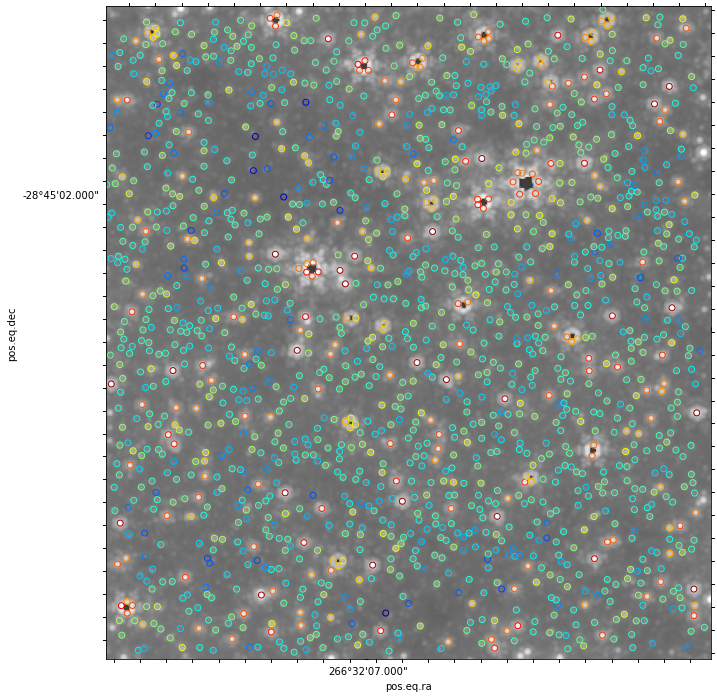

In [69]:
pl.figure(figsize=(12,12))
mask = reg.to_pixel(ww410).to_mask()
slcs,_ = mask.get_overlap_slices(fh['SCI'].data.shape)
ax = pl.subplot(projection=ww410)
#ax = pl.gca()
co = fh['SCI'].data
ax.imshow(co, cmap='gray', norm=simple_norm(co, stretch='log', max_percent=99.95), origin='lower')
crds = basetable['skycoords_f410m']
#crds = tbls[0]['skycoords']
sel = reg.contains(crds, ww410)
xx,yy = ww410[slcs].world_to_pixel(crds[sel])
#scat = ax.scatter(xx, yy, c=basetable['flux_f410m'][sel],
#                  norm=simple_norm(basetable['flux_f410m'][sel], stretch='log',), cmap='jet')
scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'), c=basetable['flux_f410m'][sel],
           norm=simple_norm(basetable['flux_f410m'][sel], stretch='log',), cmap='jet')
pl.draw()
colors = scat.get_facecolors()
scat.set_edgecolors(colors)
scat.set_facecolors('none')

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss.sss')
lat.set_major_formatter('dd:mm:ss.sss')
lon.set_ticks(spacing=1 * u.arcsec)
lat.set_ticks(spacing=1 * u.arcsec)
ax.axis((676,1043,1119,1515))

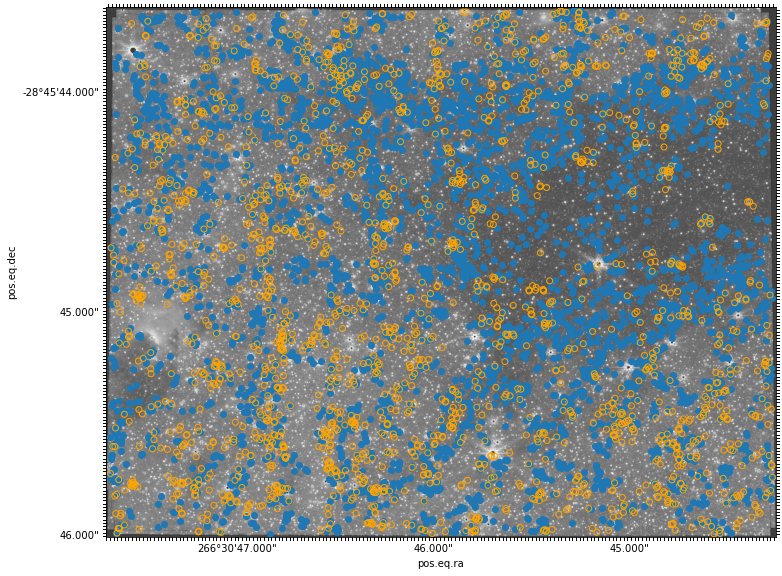

In [70]:
pl.figure(figsize=(12,12))
mask = reg.to_pixel(ww410).to_mask()
slcs,_ = mask.get_overlap_slices(fh['SCI'].data.shape)
ax = pl.subplot(projection=ww410)
#ax = pl.gca()
co = fh['SCI'].data
ax.imshow(co, cmap='gray', norm=simple_norm(co, stretch='log', max_percent=99.95), origin='lower')
crds = basetable['skycoords_f410m']
#crds = tbls[0]['skycoords']
sel = reg.contains(crds, ww410)
xx,yy = ww410[slcs].world_to_pixel(crds[sel])
##scat = ax.scatter(xx, yy, c=basetable['flux_f410m'][sel],
##                  norm=simple_norm(basetable['flux_f410m'][sel], stretch='log',), cmap='jet')
#scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'), c=basetable['flux_f410m'][sel],
#           norm=simple_norm(basetable['flux_f410m'][sel], stretch='log',), cmap='jet')
#pl.draw()
#colors = scat.get_facecolors()
#scat.set_edgecolors(colors)
#scat.set_facecolors('none')

blue_410_466 = (basetable['mag_ab_f410m'] - basetable['mag_ab_f466n']) < -1.25
pl.scatter(crds.ra[blue_410_466], crds.dec[blue_410_466], transform=ax.get_transform('world'))
blue_410_405 = (basetable['mag_ab_f410m'] - basetable['mag_ab_f405n']) < -1.00
pl.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none', transform=ax.get_transform('world'))

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss.sss')
lat.set_major_formatter('dd:mm:ss.sss')
lon.set_ticks(spacing=1 * u.arcsec)
lat.set_ticks(spacing=1 * u.arcsec)

Set OBSGEO-B to   -20.633936 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526083300.815 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


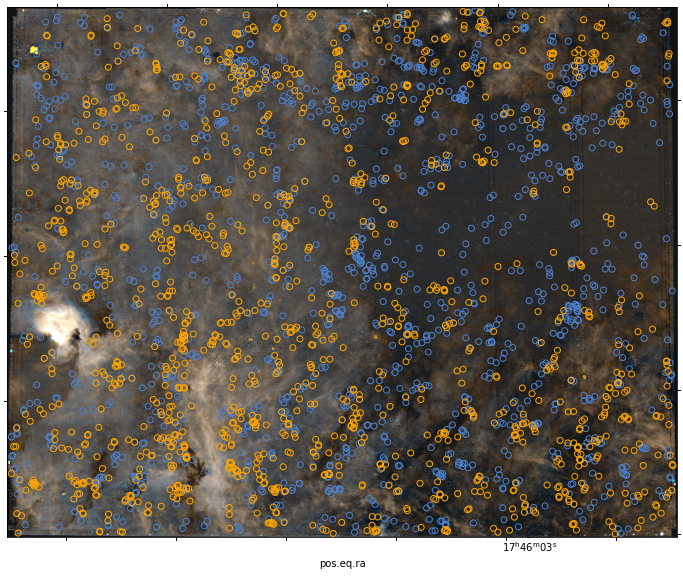

In [71]:
# This image shows only H-alpha stars
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickJWST_nrca_longwave_narrowband_rotated_lighter.png')
img_narrow = np.array(PIL.Image.open(f'{basepath}/images/BrickJWST_nrca_longwave_narrowband_rotated_lighter.png'))[::-1,:,:]
#wwi_bra_410 = avm.to_wcs(use_full_header=True)
wwi_narrow = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))


pl.figure(figsize=(12,12))
ax = pl.subplot(projection=wwi_narrow)
ax.imshow(img_narrow)

crds = basetable['skycoords_f410m']
blue_410_466 = (basetable['mag_ab_410m405'] - basetable['mag_ab_f466n']) < -1.75
ax.scatter(crds.ra[blue_410_466], crds.dec[blue_410_466], transform=ax.get_transform('world'), edgecolors=(0.3, 0.5, 0.8), facecolors='none')
blue_410_405 = (basetable['mag_ab_410m405'] - basetable['mag_ab_f405n']) < -1.25
ax.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none', transform=ax.get_transform('world'))



(25.0, 14.0)

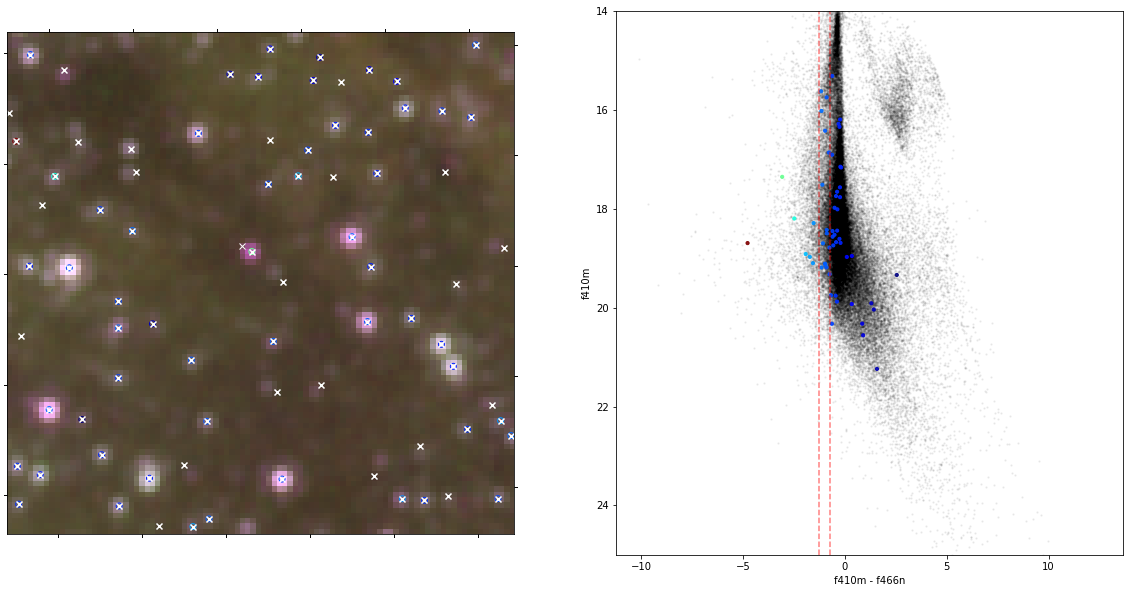

In [72]:
mask = regzoom.to_pixel(wwi).to_mask()
slcs,_ = mask.get_overlap_slices(img.shape[:2])
#co = np.array([mask.cutout(img[:,:,ii]) for ii in range(img.shape[2])])
co = img[slcs[0], slcs[1], :]

pl.figure(figsize=(20,10))
ax = pl.subplot(1,2,1, projection=wwi[slcs])
pl.imshow(co)

crds = basetable['skycoords_f410m']
sel = regzoom.contains(crds, ww410)
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
xx,yy = ww410[slcs].world_to_pixel(crds[sel])

colorby = basetable['flux_f410m']
colorby = basetable['mag_ab_f410m'] - basetable['mag_ab_f405n']
colorby = basetable['mag_ab_f410m'] - basetable['mag_ab_f466n']
#sel = sel & (colorby < -2)

scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'),
                  #edgecolor='r', facecolor='none', marker='s')#r'$\rightarrow$')
                  c=colorby[sel],
                  norm=simple_norm(colorby[sel], stretch='asinh',), cmap='jet_r')
pl.draw()
colors = scat.get_facecolors()
scat.set_edgecolors(colors)
scat.set_facecolors('none')
#pl.colorbar(mappable=scat)
axlims = ax.axis()
pl.plot(44,54, 'wx')
wwi[slcs].pixel_to_world(45,55)

# show the maximum detections
sel2 = regzoom.contains(tbls[0]['skycoords'], ww410)
ax.scatter(tbls[0]['skycoords'].ra[sel2], tbls[0]['skycoords'].dec[sel2], marker='x', color='w', transform=ax.get_transform('world'))
ax.axis(axlims)

ax2 = pl.subplot(1,2,2)
ax2.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'], basetable['mag_ab_f410m'], s=2, alpha=0.05, c='k')
ax2.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'])[sel], basetable['mag_ab_f410m'][sel], s=10, alpha=0.9,
            c=colorby[sel],
            norm=simple_norm(colorby[sel], stretch='asinh',), cmap='jet_r'
           )
ax2.axvline(-0.75, linestyle='--', color='r', alpha=0.5)
ax2.axvline(-1.25, linestyle='--', color='r', alpha=0.5)
ax2.set_ylim(pl.ylim()[::-1])
ax2.set_xlabel("f410m - f466n")
ax2.set_ylabel("f410m")
ax2.set_ylim(25,14)

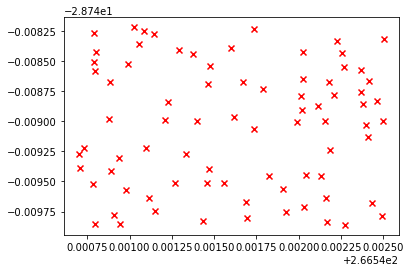

In [73]:
pl.scatter(tbls[0]['skycoords'].ra[sel2], tbls[0]['skycoords'].dec[sel2], marker='x', color='r')